# Pythonradex
Re-implementation of the RADEX code.
Adventages of pythonradex:
- faster
- provides a convenient method to read files from the LAMDA database, official website: https://home.strw.leidenuniv.nl/~moldata/.
- provides additional functionality that is not included in RADEX (treatment of overlapping lines)
- RADEX calculates the flux for all geometries using the equation which is only valid for slab geometry, pythonradex uses the correct formulae for spherical geometries.



In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
print(dir(pythonradex))

['LAMDA_file', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'atomic_transition', 'escape_probability', 'escape_probability_functions', 'flux', 'helpers', 'molecule', 'radiative_transfer', 'rate_equations']


# Getting started with pythonradex

- Radiative transfer calculation is conducted using the Cloud class which is provided by the radiative_transfer module
- Possible geometries: "Gaussian",  “rectangular”, "LVG sphere", "LVG slab”
- For LVG geometries the parameter "line_profile_type" needs to be set to “rectangular”. This ensures that the optical depth is calculated correctly.


In [3]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\co_datafile.dat"  # file downloaded from LAMDA database


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

## line width parameter "width_v" explained
- There are different interpretations of the input parameter width_v used by pythonradex
-  For static geometries, this refers to the local emission width, two kinds of local emission profiles:

  - "Gaussian" in which case width_v refers to the FWHM
  - "rectangular" in which case width_v refers to the FWHM
- For the LVG geometries (“LVG sphere” and “LVG slab”), width_v refers to the global velocity width of the cloud

## Set the parameters characterising the cloud physical conditions.
- use update_parameters method to do this.


In [4]:
## possible atributes of the cloud object
# update_parameters
# solve_radiative_transfer()
# fluxes_of_individual_transitions(solid_angle, transitions)

In [5]:
N = 1e16 / constants.centi**3  # CO column density in m-3
Tkin = 30  # kinetic temperature in [K]

# collider densities in cm-3:
para_h2_density = 1e8
ortho_h2_density = 3e8

# collider densities in m-3:
collider_densities_LTE = {
    "para-H2": para_h2_density / constants.centi**3,
    "ortho-H2": ortho_h2_density / constants.centi**3,
}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_LTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

In [6]:
# print the results
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      30.00      0.0893979        0.22303        10.6956
   2    1     230.538000      30.00        0.22303       0.257065        32.5603
   3    2     345.795990      30.00       0.257065       0.206978        46.5012
   4    3     461.040768      30.00       0.206978       0.127278        43.7039
   5    4     576.267931      30.00       0.127278       0.061878        30.1002
   6    5     691.473076      30.00       0.061878      0.0241921        15.9284
   7    6     806.651806      30.00      0.0241921     0.00768029        6.64287
   8    7     921.799700      30.00     0.00768029     0.00199175        2.21562
   9    8    1036.912393      29.99     0.00199175    0.000423615       0.596765
  10    9    1151.985452      29.99    0.000423615    7.41068e-05       0.130594
  11   10    1267.014486      29.99    7.41068e-05    1.06856e-05      0.0233645
  12   11    1381.995105   

‘poplow’ and ‘popup’ gives the fracitional populations of the lower and upper level respectively, and ‘tau_nu0’ the optical depth at the line centre.

## How fractional population is defined:

Column density of the upper state $N_u$
Fractional population of the upper  level  $n_u$ is the proportion of particles in the upper state relative to the total population of the species ($N_{tot}$):
$$n_u = \frac{N_u}{N_{tot}}$$

In [7]:
def extract_values(cloud_name, data_of_molecule):
    """Extract values from the cloud object and the data file.

    Prameters:
    ----------
    cloud_name : pythonradex.radiative_transfer.Cloud
        The cloud object that contains the radiative transfer solution.
    data_of_molecule : dict
        The data file of the molecule.

    Returns:
    Tex: np.array
        The excitation temperature of the molecule.
    tau: np.array
        The optical depth of the transitions.
    Aul : np.array
        The Einstein coefficient for spontaneous emission.
    Bul : np.array
        The Einstein coefficient for stimulated emission.
    nu0_array : np.array
        The frequency of the transition in Hz.
    Eu : np.array
        The energy of the upper level in Kelvin.
    """

    # Excitation temperature
    Tex = cloud_name.Tex

    # Optical depth (tau_nu0) of the transitions
    tau = cloud_name.tau_nu0_individual_transitions

    # get Aul, Bul
    Aul = cloud_name.emitting_molecule.A21
    Bul = cloud_name.emitting_molecule.B21

    # get the frequency of the transition in Hz
    nu0_array = cloud_name.emitting_molecule.nu0

    # extract atributtes from the data file
    levels = data_of_molecule["levels"]
    rad_transitions = data_of_molecule["radiative transitions"]
    coll_transitions = data_of_molecule["collisional transitions"]
    quantum_numbers = data_of_molecule["quantum numbers"]

    # This line extracts the "E" attribute from each object in levels and converts it to a NumPy array
    # and convert energies from jouls to kelvin
    Eu = np.array([level.E for level in levels]) / constants.k
    # alternative way to extract upper energy level, extracted from the radiative transitions
    # Eu_test = np.array([trans.up.E for trans in rad_transitions]) / constants.k

    # remove first component, sinze the first is nan
    Eu = Eu[1:]

    # get the statistical weight of the upper level
    g_weigth = np.array([level.g for level in levels])
    g_weigth = g_weigth[1:]
    # testing
    # print("Are the the two methods the same?", np.allclose(Eu, Eu_test))

    return Tex, tau, Aul, Bul, nu0_array, Eu, g_weigth


# Read file from the LAMDA database

In [8]:
# store the data
data_co = LAMDA_file.read(datafilepath, read_frequencies=True)
# LAMDA_file returns a dictionary containing the data read from the file.

# Full list of attributes
print(data_co.keys())

dict_keys(['levels', 'radiative transitions', 'collisional transitions', 'quantum numbers'])


In [9]:
# get the values from the cloud object
TexCo, tauCo, AulCo, BulCo, nu0_arrayCo, EuCo, gCO = extract_values(cloud, data_co)

# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

fluxCo = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)


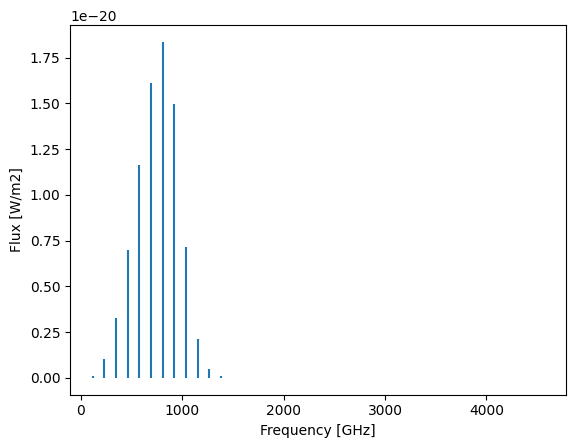

In [10]:
# plot the spectrum with individual fluxes
plt.stem(nu0_arrayCo / constants.giga, fluxCo, basefmt=" ", markerfmt=" ")

# to plot as a gaussina curve
# plt.plot(array_nu0 / constants.giga, flux, drawstyle="steps-mid")

plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux [W/m2]")
plt.show()

In [11]:
def gamma_tau_calculator(cloud_name, colum_density_species, Aul_coeff, Bul_coeff, nu0):
    """Calculates the gamma factor for radiative transitions and the optical depth

    Parameter:
    ----------
    cloud_name:
        Cloud object
    colum_density_species:
        total column density of the species in m^-2
    Aul_coeff:
        Einstein A coefficient for the transition
    Bul_coeff:
        Einstein B coefficient for the transition
    nu0:
        frequency of the transition

    Returns:
    --------
    gamma:
        gamma factors
    tau:
        optical depths
    tau_manual:
        numpy array of optical depths calculated manually
    Nu:
        upper level population density

    """
    # Calculate the total optical depth (all lines plus dust) at each input frequencies
    tau = cloud_name.tau_nu(nu0)

    ind_tau = cloud.tau_nu0_individual_transitions

    # compute upper level population density, given by: fractional population density x total column density
    # cloud.level_pop gives the fractional population density of lowest level (len 41), by removing the first element we get the fractional population density of the upper levels
    Nu = cloud.level_pop[1:] * colum_density_species

    # calculate tau manually
    tau_manual = ((constants.h * Nu * Bul_coeff) / (width_v)) * (np.exp((constants.h * nu0) / (constants.k * Tkin)) - 1)

    # calculate the gamma factor
    gamma = (8 * np.pi * constants.k * nu0**2) / (constants.h * constants.c**3 * Aul_coeff)

    # print for testing
    print("Are the the two methods for computing tau the same?", np.allclose(tau, tau_manual))
    print("Are the the two methods for computing tau the same?", np.allclose(tau, ind_tau))

    return gamma, tau, tau_manual, Nu

In [12]:
cloud.tau_nu0_individual_transitions

array([1.06955720e+01, 3.25602900e+01, 4.65011876e+01, 4.37039139e+01,
       3.01002049e+01, 1.59283569e+01, 6.64287006e+00, 2.21561998e+00,
       5.96764504e-01, 1.30593867e-01, 2.33644517e-02, 3.42355266e-03,
       4.12395947e-04, 4.09276578e-05, 3.34906529e-06, 2.26359344e-07,
       1.26474792e-08, 5.84822997e-10, 2.23961760e-11, 7.10698261e-13,
       1.86984058e-14, 4.07929430e-16, 7.39223741e-18, 1.11160939e-19,
       1.38784961e-21, 1.43914811e-23, 1.24016817e-25, 8.88898959e-28,
       5.29182729e-30, 2.62058539e-32, 1.07960801e-34, 3.70093032e-37,
       1.05525982e-39, 2.50379047e-42, 4.94586431e-45, 8.13347365e-48,
       1.11430457e-50, 1.27066956e-53, 1.20719172e-56, 9.55826762e-60])

In [13]:
# compute the gamma factor for radiative transitions
gamma_factor, tau_co, tau_co_manual, Nu_co = gamma_tau_calculator(cloud, N, AulCo, BulCo, nu0_arrayCo)

# calculate escape probability for each transition
beta = (1 - np.exp(-tau_co)) / tau_co
# Replace 0 with nan in beta
beta[beta == 0] = np.nan

# get the y axis of the plot: ln(γ_u * W / g_u)
y_values = np.log(gamma_factor * fluxCo / gCO)

# calculate get y values using column density of the upper level
y_values_new = np.log(Nu_co / gCO)
# calculate y values using column density of the upper level and beta
y_value_new_beta_consideration = np.log(Nu_co / (beta * gCO))

Are the the two methods for computing tau the same? False
Are the the two methods for computing tau the same? True


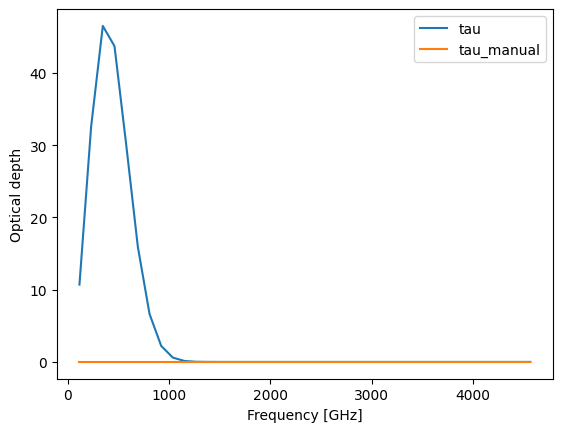

In [14]:
# plot the optical depth
plt.plot(nu0_arrayCo / constants.giga, tau_co, label="tau")
plt.plot(nu0_arrayCo / constants.giga, tau_co_manual, label="tau_manual")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Optical depth")
plt.legend()
plt.show()


In [15]:
diff_beta = y_values_new - y_value_new_beta_consideration

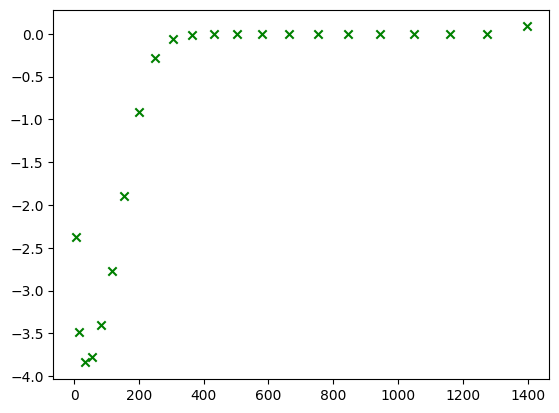

In [16]:
# plot population diagram
fig, ax = plt.subplots()

# plot y values considering escape probaility
plt.scatter(EuCo, diff_beta, marker="x", color="green", label="difference between considering beta and Nu")

## Population diagram fo CO, LTE case

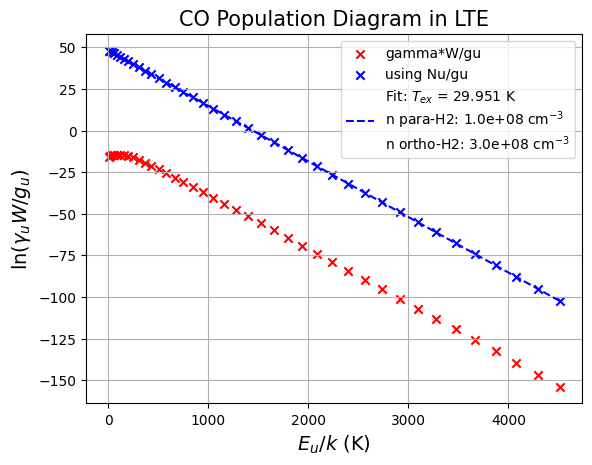

In [17]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values, marker="x", color="red", label="gamma*W/gu")
plt.scatter(EuCo, y_values_new, marker="x", color="blue", label="using Nu/gu")

# plot y values considering escape probaility
# plt.scatter(EuCo, y_value_new_beta_consideration, marker="x", color="green", label="considering beta and Nu")


plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(EuCo, y_values_new, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(
        f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)
plt.legend()
ax.grid()
plt.show()

### why the the two y axis are different???

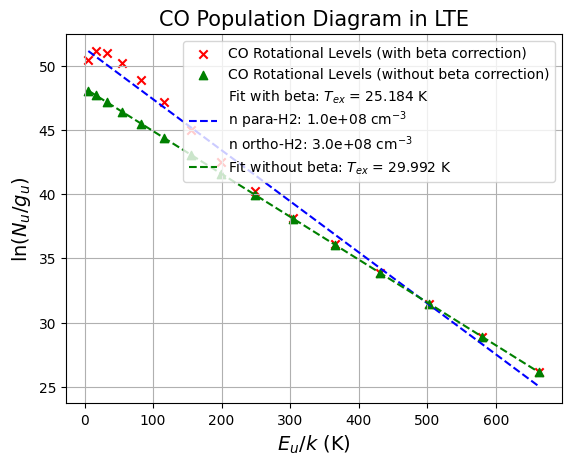

In [18]:
# Define the number of transitions
num_transitions = 15

# calculate escape probability for each transition
beta_LTE = (1 - np.exp(-tau_co)) / tau_co

# create a mask for tau_co values greater than 0.1, returns a boolean array
mask_tau_LTE = tau_co > 0.0001

# initialize y_values_LTE with the values without beta correction
y_values_LTE = np.log(Nu_co / gCO)

# apply beta correction only for values where tau_co > 0.1
y_values_LTE[mask_tau_LTE] = np.log(Nu_co[mask_tau_LTE] / (gCO[mask_tau_LTE] * beta_LTE[mask_tau_LTE]))

# plot population diagram for the first num_transitions transitions
fig, ax = plt.subplots()
plt.scatter(
    EuCo[:num_transitions],
    y_values_LTE[:num_transitions],
    marker="x",
    color="red",
    label="CO Rotational Levels (with beta correction)",
)
plt.scatter(
    EuCo[:num_transitions],
    np.log(Nu_co[:num_transitions] / gCO[:num_transitions]),
    marker="^",
    color="green",
    label="CO Rotational Levels (without beta correction)",
)

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# Fit a straight line to estimate T_ex for the first num_transitions transitions with beta correction
fit_LTE = np.polyfit(EuCo[:num_transitions], y_values_LTE[:num_transitions], 1)  # Linear fit
T_ex_LTE = -1 / fit_LTE[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex for the first num_transitions transitions without beta correction
fit_no_beta = np.polyfit(
    EuCo[:num_transitions], np.log(Nu_co[:num_transitions] / gCO[:num_transitions]), 1
)  # Linear fit
T_ex_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit_LTE = np.linspace(min(EuCo[:num_transitions]), max(EuCo[:num_transitions]), 100)
y_fit_LTE = fit_LTE[0] * x_fit_LTE + fit_LTE[1]
plt.plot(
    x_fit_LTE,
    y_fit_LTE,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {T_ex_LTE:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit_LTE + fit_no_beta[1]
plt.plot(
    x_fit_LTE,
    y_fit_no_beta,
    linestyle="--",
    color="green",
    label=(f"Fit without beta: $T_{{ex}}$ = {T_ex_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()

### why the one without beta correction is getting a better T_ex????

In [19]:
print(f"Excitation temperature with escape probability correction: {T_ex_LTE:.5g} K")
print(f"Excitation temperature without escape probability correction: {T_ex_no_beta:.5g} K")
print(f"kinetic temperature of the nebula: {Tkin} K")  # kinetic temperature in K)

Excitation temperature with escape probability correction: 25.184 K
Excitation temperature without escape probability correction: 29.992 K
kinetic temperature of the nebula: 30 K


As expected in LTE:
$$T_{ex} = T_{kin}$$

However the y axis have the wrong sign

## Consider the escape propability SKIP THIS SECTION IS FOR TESTING
Escape probability for a homogeneous, static sphere is given by:

 
$$
\beta(\tau_\nu) = \frac{3}{2\tau_\nu} \left( 1 - \frac{2}{\tau_\nu^2} + \left( \frac{2}{\tau_\nu} + \frac{2}{\tau_\nu^2} \right) e^{-\tau_\nu} \right)
$$

$\tau_\nu$ is the optical depth.

Equation for the population diagram taking into acount optical depth is: 
$$
ln{\frac{\gamma_u W}{g_u \beta}}=ln{N/Z}-\frac{E_u}{kT}
$$

In [20]:
def beta_tau_test(tau_nu):
    """Calculate the escape probability for homogeneous, static sphere"""
    if tau_nu.any() == 0:
        return np.inf  # Avoid division by zero
    return (3 / (2 * tau_nu)) * (1 - (2 / tau_nu**2) + ((2 / tau_nu) + (2 / tau_nu**2)) * np.exp(-tau_nu))


In [21]:
# get optical depth
tauCo = cloud.tau_nu(nu=nu0_arrayCo)
tauCo

array([1.06955720e+01, 3.25602900e+01, 4.65011876e+01, 4.37039139e+01,
       3.01002049e+01, 1.59283569e+01, 6.64287006e+00, 2.21561998e+00,
       5.96764504e-01, 1.30593867e-01, 2.33644517e-02, 3.42355266e-03,
       4.12395947e-04, 4.09276578e-05, 3.34906529e-06, 2.26359344e-07,
       1.26474792e-08, 5.84822997e-10, 2.23961760e-11, 7.10698261e-13,
       1.86984058e-14, 4.07929430e-16, 7.39223741e-18, 1.11160939e-19,
       1.38784961e-21, 1.43914811e-23, 1.24016817e-25, 8.88898959e-28,
       5.29182729e-30, 2.62058539e-32, 1.07960801e-34, 3.70093032e-37,
       1.05525982e-39, 2.50379047e-42, 4.94586431e-45, 8.13347365e-48,
       1.11430457e-50, 1.27066956e-53, 1.20719172e-56, 9.55826762e-60])

In [22]:
# # plot population diagram
# fig, ax = plt.subplots()
# plt.scatter(Eu_co, y_values, marker="x", color="red", label="CO Rotational Levels")
# plt.scatter(Eu_co, y_values_corrected, marker="x", color="blue", label="CO Rotational Levels with optical depth correction")
# plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
# plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
# plt.title("CO Population Diagram in LTE", fontsize=15)

# # # Fit a straight line to estimate T_ex
# fit = np.polyfit(Eu_co, y_values, 1)  # Linear fit
# T_ex = -1 / fit[0]  # Rotational temperature from slope

# # Plot the best-fit line
# x_fit = np.linspace(min(Eu_co), max(Eu_co), 100)
# y_fit = fit[0] * x_fit + fit[1]
# plt.plot(
#     x_fit,
#     y_fit,
#     linestyle="--",
#     color="blue",
#     label=(f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {collider_densities_LTE['para-H2']:.1e} m$^{{-3}}$\nn ortho-H2: {collider_densities_LTE['ortho-H2']:.1e} m$^{{-3}}$"),
# )
# plt.legend()
# ax.grid()
# plt.show()

# Line profile of CO, LTE case


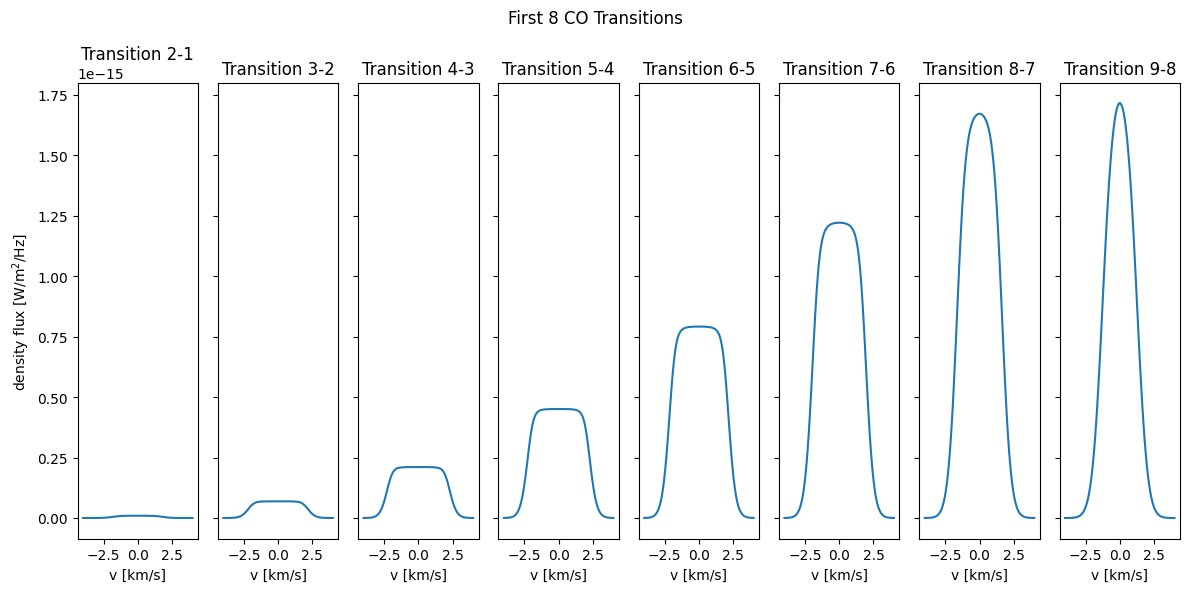

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(
        nu=nu, solid_angle=source_solid_angle
    )  # Compute spectrum, this give the flux density in W/m^2/Hz

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum * nu)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"density flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

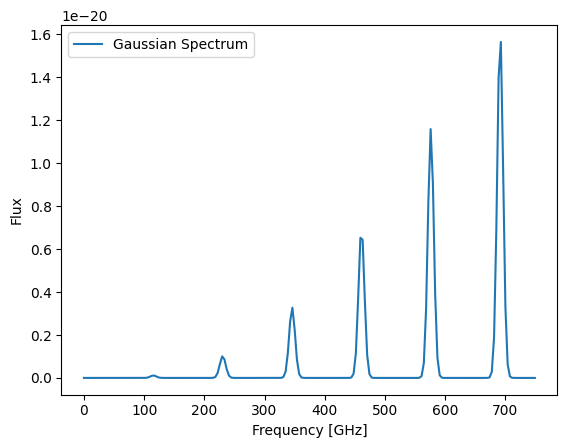

In [24]:
def gaussian(x, amp, cen, fwhm):
    """
    Gaussian function.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        amp: float, the amplitude of the Gaussian
        cen: float, the center of the Gaussian
        fwhm: float, the full width at half maximum of the Gaussian

    Returns:
        The Gaussian evaluated at x.
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))


# Define the model: a sum of Gaussians.
def model_spectrum(x, params):
    """
    Create spectrum, sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, fwhm] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        total += gaussian(x, amp, cen, fwhm)
    return total


# arbitarry fwhm
fwhm_frequancy = nu0_arrayCo[0] * 0.1

# Example usage
x = np.linspace(0, nu0_arrayCo[5] + 5 * fwhm_frequancy, 200)
params = []
for i in range(6):
    # fwhm_frequancy = nu0_arrayCo[i] * 0.1
    params.extend([fluxCo[i], nu0_arrayCo[i], fwhm_frequancy])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.show()

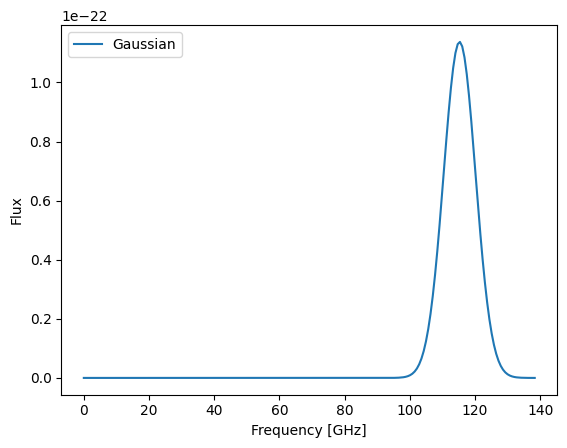

In [25]:
# Example usage
x = np.linspace(0, nu0_arrayCo[0] + 2 * fwhm_frequancy, 200)
gaus_frequancy = gaussian(x, fluxCo[0], nu0_arrayCo[0], fwhm_frequancy)

# plot frequency vs flux
fig, ax = plt.subplots()
plt.plot(x / constants.giga, gaus_frequancy, label="Gaussian")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.show()

# CO for non-LTE case

## Update cloud

In [26]:
# update the claud using low densities of h2
# collider densities in cm-3:
para_h2_density_nonLTE = 1e3
ortho_h2_density_nonLTE = 3e3

# collider densities in m-3:
collider_densities_LTE = {
    "para-H2": para_h2_density_nonLTE / constants.centi**3,
    "ortho-H2": ortho_h2_density_nonLTE / constants.centi**3,
}


collider_densities_nonLTE = {
    "para-H2": 2e2 / constants.centi**3,
    "ortho-H2": 6e2 / constants.centi**3,
}

cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_nonLTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

cloud.solve_radiative_transfer()

In [27]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      26.37       0.114042       0.277377        15.3338
   2    1     230.538000      25.73       0.277377       0.300739         45.881
   3    2     345.795990      23.61       0.300739       0.208469        64.6417
   4    3     461.040768      19.28       0.208469      0.0850761        57.5923
   5    4     576.267931      13.70      0.0850761      0.0138153        28.9699
   6    5     691.473076       9.33      0.0138153    0.000466562        5.16249
   7    6     806.651806      10.54    0.000466562    1.36803e-05        0.17225
   8    7     921.799700      16.49    1.36803e-05    1.05986e-06     0.00476769
   9    8    1036.912393      18.45    1.05986e-06    7.97705e-08    0.000365775
  10    9    1151.985452      19.44    7.97705e-08    5.12816e-09    2.75169e-05
  11   10    1267.014486      20.16    5.12816e-09    2.75186e-10    1.77071e-06
  12   11    1381.995105   

## Plot spectrum lines, non-LTE case

In [28]:
# get the values from the non-LtE cloud object
TexCo_nonLTE, tauCo_nonLTE, _, _, _, _, _ = extract_values(cloud, data_co)

# compute the gamma factor for radiative transitions
gamma_factor_nonLTE, tau_co_nonLTE, tau_co_manual_nonLTE, Nu_co_nonLTE = gamma_tau_calculator(
    cloud, N, AulCo, BulCo, nu0_arrayCo
)

Are the the two methods for computing tau the same? False
Are the the two methods for computing tau the same? True


In [29]:
# calculate the observed fluxes [W/m2], outputed as a list
flux_nonLTE = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)

# convert flux to np.array
flux_nonLTE = np.array(flux_nonLTE)

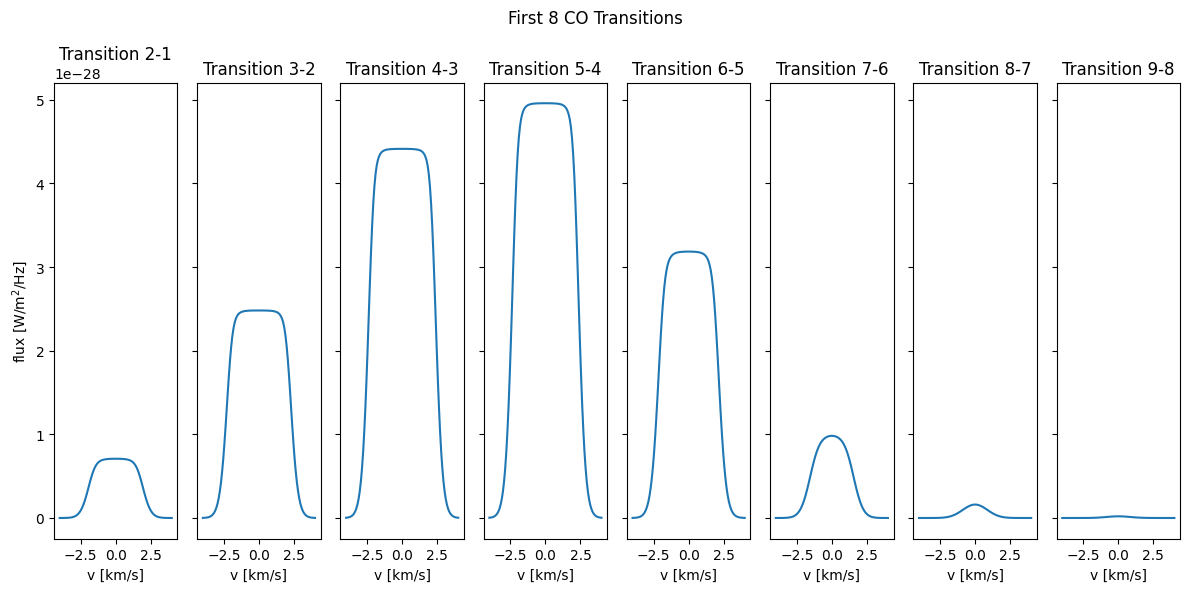

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum

    ax = axes[i]  # Select subplot in 2x4 grid
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

## Plot CO population diagram, non-LTE case

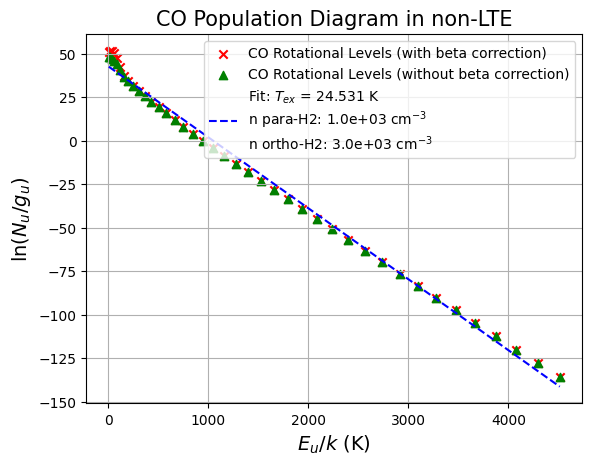

In [31]:
# calculate escape probability for each transition
beta_nonLTE = (1 - np.exp(-tau_co_nonLTE)) / tau_co_nonLTE

# create a mask for tau_co_nonLTE values greater than 0.1, returns a boolean array
mask_tau = tau_co_nonLTE > 0.1

# initialize y_values_nonLTE with the values without beta correction
y_values_nonLTE = np.log(Nu_co_nonLTE / gCO)

# apply beta correction only for values where tau_co_nonLTE > 0.1
y_values_nonLTE[mask_tau] = np.log(Nu_co_nonLTE[mask_tau] / (gCO[mask_tau] * beta_nonLTE[mask_tau]))

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values_nonLTE, marker="x", color="red", label="CO Rotational Levels (with beta correction)")
plt.scatter(
    EuCo, np.log(Nu_co_nonLTE / gCO), marker="^", color="green", label="CO Rotational Levels (without beta correction)"
)
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in non-LTE", fontsize=15)

# Fit a straight line to estimate T_ex
fit = np.polyfit(EuCo, y_values_nonLTE, 1)  # Linear fit
T_ex_nonLTE = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(
        f"Fit: $T_{{ex}}$ = {T_ex_nonLTE:.5g} K\nn para-H2: {para_h2_density_nonLTE:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density_nonLTE:.1e} cm$^{{-3}}$"
    ),
)
plt.legend()
ax.grid()
plt.show()

In [32]:
print(f"Excitation temperature: {T_ex_nonLTE:.5g} K")
print(f"Kinetic temperature of the cloud: {Tkin} K")  # kinetic temperature in K)

Excitation temperature: 24.531 K
Kinetic temperature of the cloud: 30 K


# Plot population diagram for CH3OH-e

In [33]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CH3OH from LAMBDA database
datafilepath_methanol = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"  # file downloaded from LAMDA database

# store the data
data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
Ntot_emeth = 1e16 / constants.centi**2  # total column density in m^-2
line_profile_type = "Gaussian"  # line profile, can be "rectangular" or "Gaussian"
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

N = 1e16 / constants.centi**2  # CH3OH_e column density in m-2
# Tkin = 120  # kinetic temperature in [K]

# collider densities in m-3, for ch3oh-e ther is only one input parameter, hence no distinction between para- an otho-H2
LTE_collider_densities_h2only = {"H2": 1e7 / constants.centi**3}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer, i.e. calculate the level population with an iterative method
cloud_metahnol.solve_radiative_transfer()

79-78: tau_nu0 = -0.0448
46-45: tau_nu0 = -0.4
28-27: tau_nu0 = -5.9e-05
26-24: tau_nu0 = -3.08e-05
91-89: tau_nu0 = -4.29e-05
13-12: tau_nu0 = -0.972
18-17: tau_nu0 = -1.01
10-8: tau_nu0 = -0.62
23-22: tau_nu0 = -0.885
30-27: tau_nu0 = -0.709
37-36: tau_nu0 = -0.525
44-43: tau_nu0 = -0.349
54-53: tau_nu0 = -0.212
65-64: tau_nu0 = -0.114
49-48: tau_nu0 = -1.26e-12
79-77: tau_nu0 = -0.0537
92-91: tau_nu0 = -0.0226
105-104: tau_nu0 = -0.00759
121-120: tau_nu0 = -0.00279
68-66: tau_nu0 = -1.77e-05
9-7: tau_nu0 = -2.13
38-37: tau_nu0 = -0.000276
86-85: tau_nu0 = -0.000588
12-11: tau_nu0 = -1.63e-05
10-7: tau_nu0 = -1.54e-06
92-89: tau_nu0 = -0.0177
59-56: tau_nu0 = -0.211
38-36: tau_nu0 = -4.67e-05
13-11: tau_nu0 = -7.31e-08
33-31: tau_nu0 = -2.32e-05
104-103: tau_nu0 = -1.56e-05
58-55: tau_nu0 = -2.46e-12
80-78: tau_nu0 = -1.38e-05
16-14: tau_nu0 = -1.33
46-44: tau_nu0 = -0.000206
75-73: tau_nu0 = -0.000565
17-15: tau_nu0 = -1.62e-06
105-103: tau_nu0 = -0.00584
69-68: tau_nu0 = -0.0975
16

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [ ]:
# extract_values
TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH = extract_values(cloud_metahnol, data_methanol)

# Take only N first transitions
firstN_transitions = 10
TexCH3OH = TexCH3OH[:firstN_transitions]
tauCH3OH = tauCH3OH[:firstN_transitions]
AulCH3OH = AulCH3OH[:firstN_transitions]
BulCH3OH = BulCH3OH[:firstN_transitions]
nu0_arrayCH3OH = nu0_arrayCH3OH[:firstN_transitions]
EuCH3OH = EuCH3OH[:firstN_transitions]
gCH3OH = gCH3OH[:firstN_transitions]


# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2


fluxCo = cloud.fluxes_of_individual_transitions(transitions=list(range(10)), solid_angle=source_solid_angle)

In [52]:
fluxCo

array([1.06896031e-22, 8.91547325e-22, 2.48649236e-21, 3.67138369e-21,
       2.67721687e-21, 7.04399982e-22, 9.34680605e-23, 1.29715857e-23,
       1.56982047e-24, 1.53887062e-25])

In [38]:
nu0_arrayCH3OH

array([2.93796609e+09, 2.23045589e+10])

In [39]:
cloud_metahnol.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
  79   78       2.937966      -0.08    0.000109692    0.000700937     -0.0447742
  14   13       3.387655       1.07      0.0310485      0.0342973    1.16013e-05
  96   95       7.284957       0.75    1.43109e-05    9.84621e-06    0.000354654
  30   28       9.413483       2.05      0.0251887      0.0175044    0.000288731
  46   45       9.923130      -0.60     0.00345069     0.00850416      -0.399662
   5    4      12.171574       1.84      0.0636878      0.0331199         2.8838
 132  131      14.899685       0.44    5.30489e-06    9.83594e-07    5.16175e-06
  28   27      15.619187      -1.97      0.0149354      0.0251887   -5.89793e-05
  58   56      18.347298       1.14     0.00160581    0.000663081    1.82708e-05
   8    7      19.966178      14.54      0.0365909      0.0244691       0.180725
  42   40      22.304559       1.57      0.0023658     0.00101352    4.24624e-13
  78   77      23.383812   

In [40]:
# compute flux for the first 10 transitions

# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

frequancy_test = np.arange(1, 20, 0.005) * constants.giga

# spectrum_methanol = cloud_metahnol.spectrum(solid_angle=source_solid_angle, nu=nu0_arrayCH3OH[:10])

spectrum_methanol = cloud_metahnol.spectrum(solid_angle=source_solid_angle, nu=frequancy_test)

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\flux.py:175: RuntimeWarning: invalid value encountered in divide
  S_tot = np.where(self.tau_nu_tot==0,0,S_nu/self.tau_nu_tot)


In [41]:
spectrum_methanol

array([0., 0., 0., ..., 0., 0., 0.])